# Bayesian Linear Regression

This lab is focused on Bayesian linear regression.  Our goal is to estimate a function $f(x) : \mathbb{R}\rightarrow\mathbb{R}$ given $N$ observations $\{(x_1,f(x_1)),\ldots, (x_N,f(x_N))\}$.

Assume an approximation $\tilde{f}(x)$ of the form
$$
\tilde{f}(x) = \sum_{p=0}^P m_p x^p.
$$
The regression problem is to characterize the coefficients $m=[m_0,\ldots,m_P]$, which we will do in a Bayesian setting.

### Goals:
By the end of this lab, you will be able to
- Derive the posterior distribution for linear-Gaussian problems.
- Characterize prior and posterior predictive distributions.

### Formulation:

Let $y$ denote the "observable" random variable denoting the models outputs and let $\bar{y}$ be a vector in $\mathbb{R}^N$ denoting the specific observations $f(x_1), \ldots, f(x_N)$.  Our goal is to characterize the distribution of $m$ given $y=\bar{y}$.  Bayes' rule gives
$$
\pi(m | y=\bar{y}) \propto \pi(y=\bar{y} | m) \pi(m).
$$
The two major components of this density are the prior density over the coefficeints $\pi(m)$ and the likelihood function $\pi(y|m)$.  The prior represents should contain any information we might have before obtaining the observation $\bar{y}$.  The likelihood function $\pi(y | m)$ defines a statistical model for the data.

For the prior distribution, we choose a Gaussian prior with a large variance.  In particular, 
$$
\pi(m) = N(0,\sigma_m^2 I),
$$ 
with $\sigma_m^2 = 100$.

> **Question:** Do you think this is a valid prior?  What if we knew $\frac{df}{dx}>0$?  What would change?


To form the likelihood function, we need to relate the expansion coefficients $m$ with the observable random variable $y$. To do this, consider the Vandermonde matrix 
$$
V = \left[\begin{array}{cccc}1 & x_1 & \ldots & x_1^P\\ \vdots & \vdots & & \vdots \\ 1 & x_N & \ldots & x_N^P \end{array}\right].
$$
Using $V$, a common choice is to assume $y$ is given by
$$
y = Vm + \epsilon,
$$
where $\epsilon \sim N(0,\Sigma)$ is a zero mean random variable with covariance $\Sigma$.  The additive error $\epsilon$ is often called the observation noise.  Here, we will further assume that $\Sigma = \sigma_y^2 I$.

> **Question:** Is this a reasonable model of $y$?  What if the noise was multiplicative?

With this additive error, the likelihood function takes the form
$$
\pi(y | m) = N(Vm, \Sigma).
$$

## Imports

In [1]:
import sys
sys.path.insert(0,'/home/fenics/Installations/MUQ_INSTALL/lib')

import numpy as np
import matplotlib.pyplot as plt

from PlotUtilities import PlotGaussianPDF


## Generate Synthetic Observations

In [2]:
def TrueFunc(x):
    return np.sin(4.5*x)

In [3]:
numObs = 20
trueNoiseStd = 2e-2
obsLocs = np.linspace(0,1,numObs)

obsData = TrueFunc(obsLocs) + trueNoiseStd*np.random.randn(numObs)

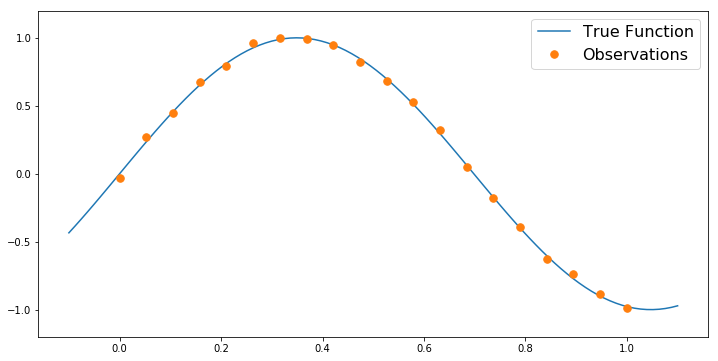

In [4]:
numPlot = 100

plotx = np.linspace(-0.1, 1.1, numPlot)

plt.figure(figsize=(12,6))
plt.plot(plotx, TrueFunc(plotx),label='True Function')
plt.plot(obsLocs,obsData,'.', markersize=15, label = 'Observations')

plt.ylim([-1.2,1.2])
plt.legend(fontsize=16)

## Form the prior

In [5]:
polyOrder = 4

priorMean = np.zeros(polyOrder+1)
priorCov = (10*10)*np.eye(polyOrder+1)

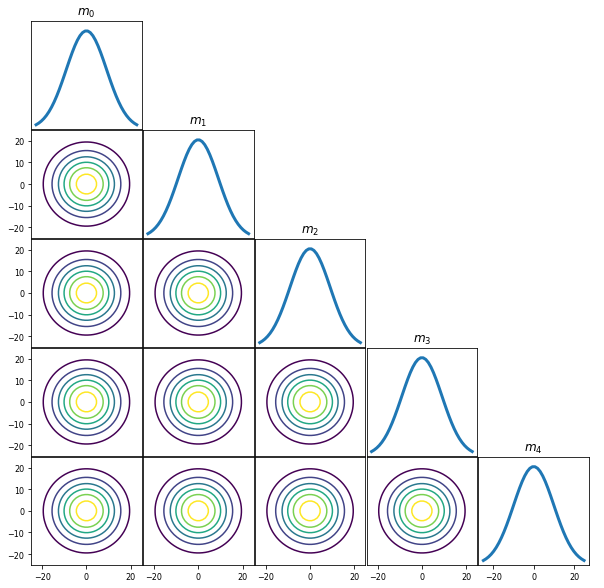

In [6]:
PlotGaussianPDF(priorMean,priorCov)

## Prior predictive

In [7]:
predV = np.ones((numPlot,polyOrder+1))
for p in range(1,polyOrder+1): 
    predV[:,p] = np.power(plotx, p)
    
predMean = np.dot(predV, priorMean)
predCov = np.dot(predV, np.dot(priorCov, predV.T))

predStd = np.sqrt(np.diag(predCov))

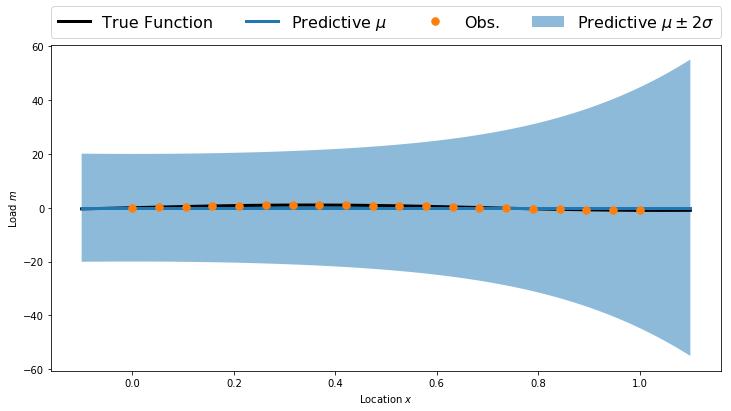

In [8]:
plt.figure(figsize=(12,6))

plt.fill_between(plotx, predMean-2.0*predStd, predMean+2.0*predStd, alpha=0.5, label='Predictive $\mu\pm2\sigma$')
plt.plot(plotx, TrueFunc(plotx), 'k', linewidth=3, label='True Function')
plt.plot(plotx, predMean, linewidth=3, label='Predictive $\mu$')
plt.plot(obsLocs,obsData,'.', markersize=15, label = 'Obs.')

plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3, ncol=4, mode="expand", borderaxespad=0., fontsize=16)
plt.xlabel('Location $x$')
plt.ylabel('Load $m$')
plt.show()

## Form the polynomial model

In [9]:
V = np.ones((numObs,polyOrder+1))
for p in range(1,polyOrder+1): 
    V[:,p] = np.power(obsLocs, p)

## Compute the posterior distribution

In [10]:
modelNoiseStd = 1.0*trueNoiseStd
noiseCov = modelNoiseStd * np.eye(numObs)

Vsigma = np.dot(V,priorCov)
predCov = np.dot(Vsigma, V.T) + noiseCov

postCov = priorCov - np.dot(Vsigma.T, np.linalg.solve(predCov, Vsigma))
postMean = priorMean + np.dot(Vsigma.T, np.linalg.solve(predCov, obsData))

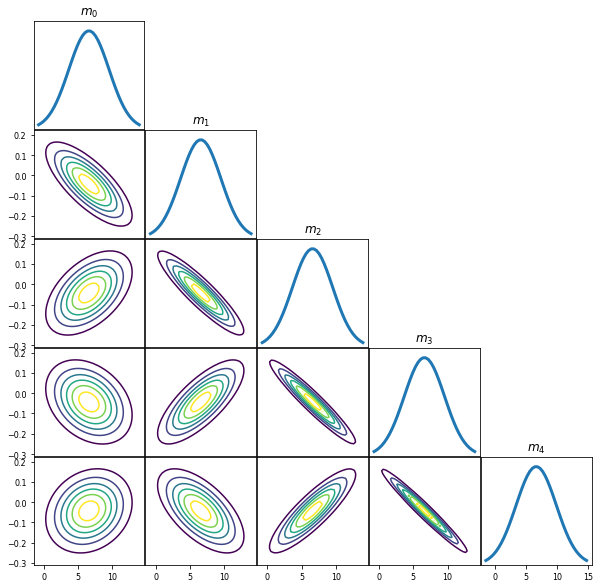

In [11]:
PlotGaussianPDF(postMean,postCov)

## Posterior Predictive

In [12]:
predMean = np.dot(predV, postMean)
predCov = np.dot(predV, np.dot(postCov, predV.T))

predStd = np.sqrt(np.diag(predCov))

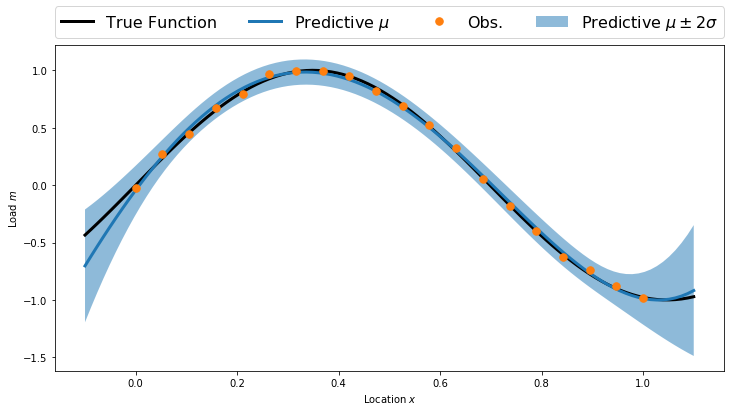

In [13]:
plt.figure(figsize=(12,6))

plt.fill_between(plotx, predMean-2.0*predStd, predMean+2.0*predStd, alpha=0.5, label='Predictive $\mu\pm2\sigma$')
plt.plot(plotx, TrueFunc(plotx), 'k', linewidth=3, label='True Function')
plt.plot(plotx, predMean, linewidth=3, label='Predictive $\mu$')
plt.plot(obsLocs,obsData,'.', markersize=15, label = 'Obs.')

plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3, ncol=4, mode="expand", borderaxespad=0., fontsize=16)
plt.xlabel('Location $x$')
plt.ylabel('Load $m$')
plt.show()

# Repeat with MUQ

In [14]:
import pymuqModeling as mm

#### Set up prior

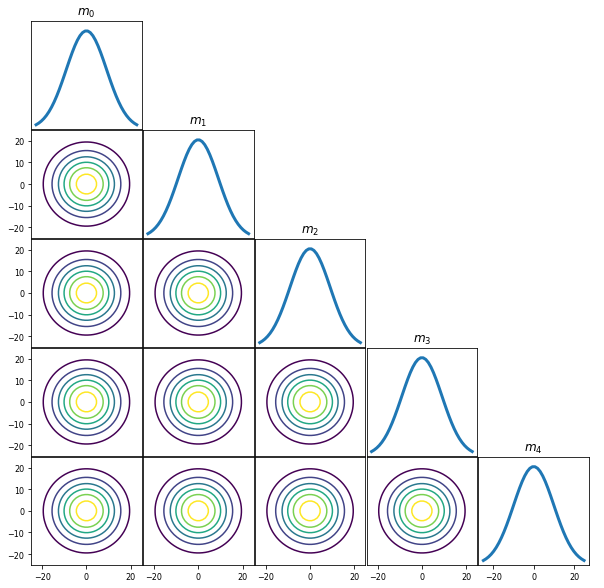

In [15]:
priorMean = np.zeros(polyOrder+1)
priorCov = (10*10)*np.eye(polyOrder+1)

prior = mm.Gaussian(priorMean, priorCov)
PlotGaussianPDF(prior.GetMean(), prior.GetCovariance())

#### Compute posterior

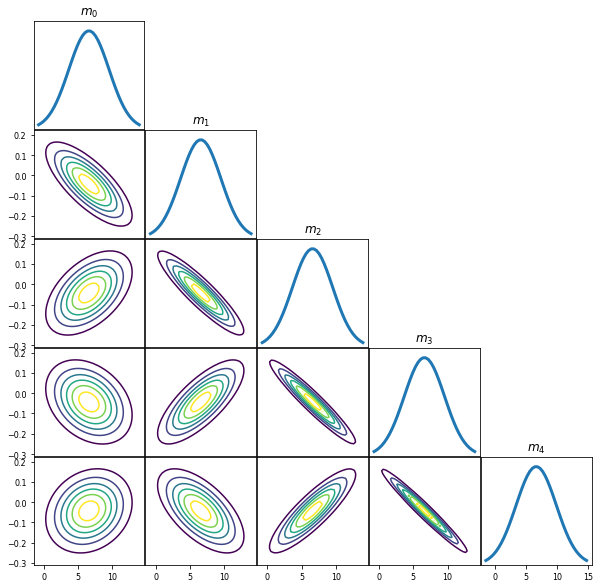

In [16]:
post = prior.Condition(V, obsData, noiseCov)

PlotGaussianPDF(post.GetMean(),post.GetCovariance())

## Prior Predictive Samples

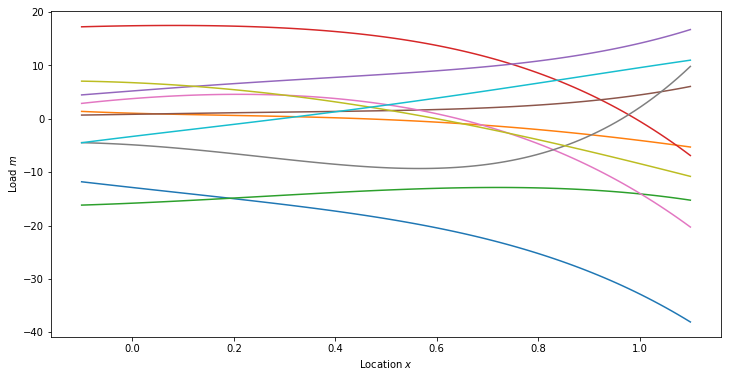

In [17]:
numSamps = 10

priorSamps = np.zeros((priorMean.shape[0], numSamps))
for i in range(numSamps):
    priorSamps[:,i] = prior.Sample()
    
priorPredSamps = np.dot(predV, priorSamps)

plt.figure(figsize=(12,6))
for i in range(numSamps):
    plt.plot(plotx, priorPredSamps[:,i])
    
plt.xlabel('Location $x$')
plt.ylabel('Load $m$')
plt.show()

## Posterior Predictive Samples

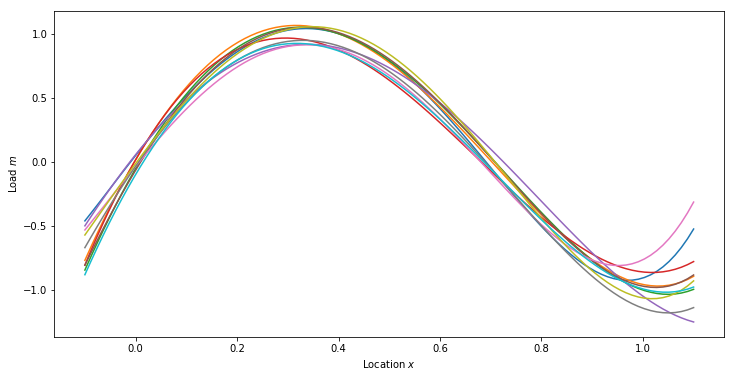

In [18]:
numSamps = 10

postSamps = np.zeros((priorMean.shape[0], numSamps))
for i in range(numSamps):
    postSamps[:,i] = post.Sample()

postPredSamps = np.dot(predV, postSamps)

plt.figure(figsize=(12,6))
for i in range(numSamps):
    plt.plot(plotx, postPredSamps[:,i])
    
plt.xlabel('Location $x$')
plt.ylabel('Load $m$')
plt.show()